In [1]:
#general import
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import clear_output, display
import pandas as pd

#saving data to google form
import requests
from bs4 import BeautifulSoup
import json 

#button imports
import time
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
from jupyter_ui_poll import ui_events

%matplotlib widget

In [2]:
#define the function to draw cubes 
def draw_cubes(cubes, ticks=False, grid=True, view='', flip='', rot=0, ax3d=None):
    
    # create empty cube
    cubes_to_draw = np.zeros(cubes.shape)
    
    # set elements to 1 where colour is not empty
    cubes_to_draw[cubes!=''] = 1

    # make figure and 3d axes for plotting
    if ax3d is None:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d', proj_type='ortho', box_aspect=(4,4,4))
    else:
        ax = ax3d
        
    nx, ny, nz = cubes.shape

    ax.axes.set_xlim3d(0, nx) 
    ax.axes.set_ylim3d(0, ny) 
    ax.axes.set_zlim3d(0, nz) 

    # The cubes can be plotted using a 3D voxels plot
    ax.voxels(cubes_to_draw, facecolors=cubes, edgecolors='k', shade=False);

    # view argument allows users to set a 2D projection
    if view == 'xy': ax.view_init(90, -90, 0+rot)
    elif view == '-xy': ax.view_init(-90, 90, 0-rot)
    elif view == 'xz': ax.view_init(0, -90, 0+rot)
    elif view == '-xz': ax.view_init(0, 90, 0-rot)
    elif view == 'yz': ax.view_init(0, 0, 0+rot)
    elif view == '-yz': ax.view_init(0, 180, 0-rot)
    else:   ax.view_init(azim=ax.azim+rot)

    # flip argument allows user to show a mirror image
    # flip='x' reverses image in x direction etc.
    if 'x' in flip: ax.axes.set_xlim3d(nx, 0) 
    if 'y' in flip: ax.axes.set_ylim3d(ny, 0) 
    if 'z' in flip: ax.axes.set_zlim3d(nz, 0) 

    # style figure ticks and grid lines
    if ticks==False: 
        for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
            axis.set_ticklabels([])
            axis.line.set_linestyle('')
            axis._axinfo['tick']['inward_factor'] = 0.0
            axis._axinfo['tick']['outward_factor'] = 0.0
            
    if grid==False and ticks==False: ax.set_axis_off()
    
    if ax3d is not None:
        # return axes with result
        return
    else:
        # show image
        display(fig)

        # delete figure
        plt.close(fig)

    return 

In [3]:
#define the send_to_google_form function 
def send_to_google_form(data_dict, form_url):
    ''' Helper function to upload information to a corresponding google form 
        You are not expected to follow the code within this function!
    '''
    form_id = form_url[34:90]
    view_form_url = f'https://docs.google.com/forms/d/e/{form_id}/viewform'
    post_form_url = f'https://docs.google.com/forms/d/e/{form_id}/formResponse'

    page = requests.get(view_form_url)
    content = BeautifulSoup(page.content, "html.parser").find('script', type='text/javascript')
    content = content.text[27:-1]
    result = json.loads(content)[1][1]
    form_dict = {}
    
    loaded_all = True
    for item in result:
        if item[1] not in data_dict:
            print(f"Form item {item[1]} not found. Data not uploaded.")
            loaded_all = False
            return False
        form_dict[f'entry.{item[4][0][0]}'] = data_dict[item[1]]
        
    
    post_result = requests.post(post_form_url, data=form_dict)
    return post_result.ok

In [4]:
def register_event(btn):
    # display button description in output area
    event_info['type'] = "click"
    event_info['description'] = btn.description
    event_info['time'] = time.time()
    return

In [5]:
#define the buttons
event_info = {
    'type': '',
    'description': '',
    'time': -1
}

def wait_for_event(timeout=-1, interval=0.001, max_rate=20, allow_interupt=True):    
    start_wait = time.time()

    # set event info to be empty
    # as this is dict we can change entries
    # directly without using
    # the global keyword
    event_info['type'] = ""
    event_info['description'] = ""
    event_info['time'] = -1

    n_proc = int(max_rate*interval)+1
    
    with ui_events() as ui_poll:
        keep_looping = True
        while keep_looping==True:
            # process UI events
            ui_poll(n_proc)

            # end loop if we have waited more than the timeout period
            if (timeout != -1) and (time.time() > start_wait + timeout):
                keep_looping = False
                
            # end loop if event has occured
            if allow_interupt==True and event_info['description']!="":
                keep_looping = False
                
            # add pause before looping
            # to check events again
            time.sleep(interval)
    
    # return event description after wait ends
    # will be set to empty string '' if no event occured
    return event_info

# this function lets buttons 
# register events when clicked

In [6]:
#Scoring System 
score = 0

In [7]:
# Welcome
print("Welcome to the Spatial Resoning Test (SRT).")
time.sleep(1)
print("Please enter your group number and student number to continue the test.")
time.sleep(1)
print ("Please enter your Group number (number only)")
group_number = input('>')
time.sleep(0.5)
print("Please enter your student ID")
student_ID = input (">")


Welcome to the Spatial Resoning Test (SRT).
Please enter your group number and student number to continue the test.
Please enter your Group number (number only)


> tesst


Please enter your student ID


> tesst


Spatial Resoning Test (SRT) Question 1
Please choose the 2D projection that CANNOT be obtained by rotating the 3D arrangement in space.


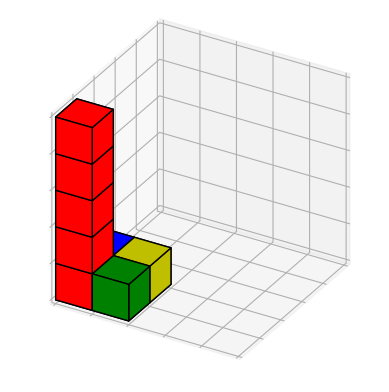

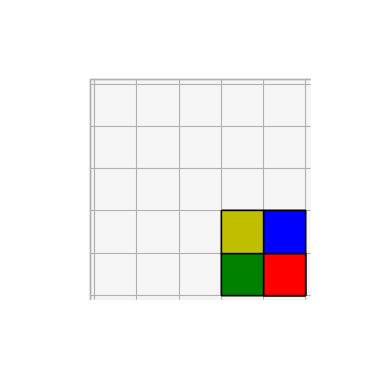

a


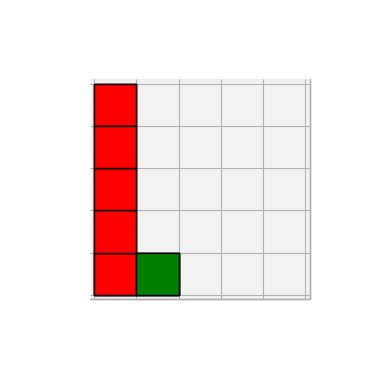

b


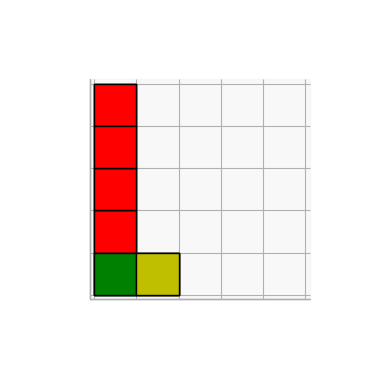

c


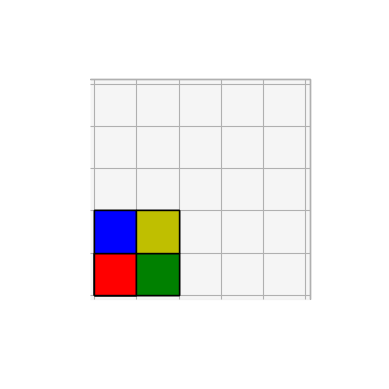

d


Enter a,b,c or d: a


correct!
You took 1.06 seconds


In [8]:
#Question 1

#Welcome
print("Spatial Resoning Test (SRT) Question 1")
time.sleep(1)
print("Please choose the 2D projection that CANNOT be obtained by rotating the 3D arrangement in space.")
time.sleep(1)

# Q1 cubes drawing
cubes1 = np.full((5,5,5),'')
cubes1[0,0,0:5] = 'r' 
cubes1[1,0,0] = 'g'
cubes1[0,1,0] = 'b'
cubes1[1,1,0] = 'y'
# draw the result
draw_cubes(cubes1)
time.sleep(1)


#draw projections
draw_cubes(cubes1, view='-xy')# draw the view from bottom in XY plane
print ("a")
draw_cubes(cubes1, view='xz')# draw the side view in XZ direction
print ("b")
draw_cubes(cubes1, view='yz')# draw the side view in YZ direction
print ("c")
draw_cubes(cubes1, flip='z', view='xy')# display the projection obtained from the flipped arrangement.
print ("d")
start_time_q1=time.time()

#interaction with user    
q1_ans = input("Enter a,b,c or d:")

if q1_ans == "a":
    print ("correct!")
    score = score + 1 
    q1_mark = 1
else:
    print ("The correct answer is a")
    q1_mark = 0

#time used
end_time_q1=time.time()
time_taken_q1=end_time_q1 - start_time_q1
print (f"You took {time_taken_q1:.2f} seconds")

Welcome to the Spatial Resoning Test (SRT) Question 2
Please choose the 2D projection that cannot be obtained by rotating the 3D arrangement in space.


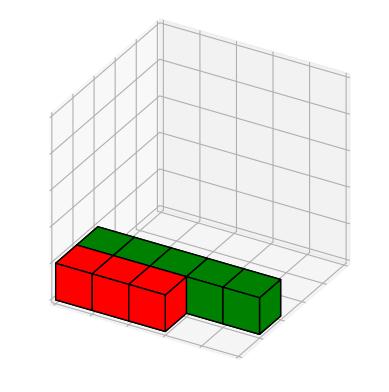

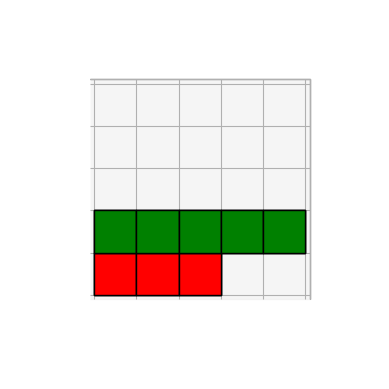

a


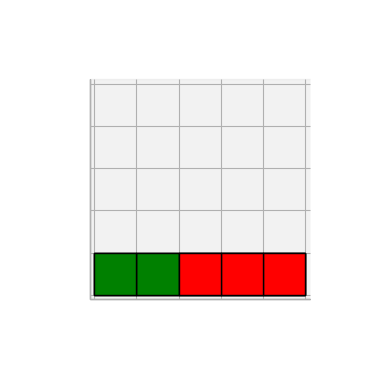

b


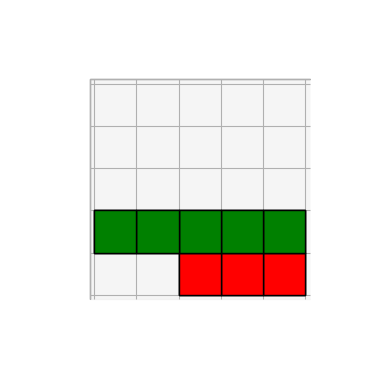

c


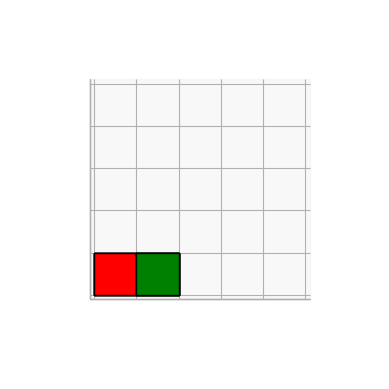

d


Enter a,b,c or d: b


correct!
You took 1.31 seconds


In [9]:
#Question 2

#Welcome
print("Welcome to the Spatial Resoning Test (SRT) Question 2")
time.sleep(1)
print("Please choose the 2D projection that cannot be obtained by rotating the 3D arrangement in space.")
time.sleep(1)

#Q2 cubes drawing
cubes2 = np.full((5,5,5),'')
cubes2[0:3,0,0] = 'r'
cubes2[0:6,1,0] = 'g'
draw_cubes(cubes2)
time.sleep(1)

#draw projections
draw_cubes(cubes2, view='xy')# draw the view from bottom in XY plane
print("a")
draw_cubes(cubes2, flip='x', view='xz')# display the projection obtained from the flipped arrangement.
print("b")
draw_cubes(cubes2, view='-xy')# draw the side view in -xy direction
print("c")
draw_cubes(cubes2, view='yz')# draw the side view in YZ direction
print("d")
start_time_q2=time.time()

#interaction with user
q2_ans = input("Enter a,b,c or d:")

if q2_ans == "b":
    print ("correct!")
    score = score + 1 
    q2_mark = 1
else:
    print ("The correct answer is b")
    q2_mark = 0
    
end_time_q2=time.time()
time_taken_q2=end_time_q2 - start_time_q2
print (f"You took {time_taken_q2:.2f} seconds")

Welcome to the Spatial Resoning Test (SRT) Question 3
Please choose the 2D projection that cannot be obtained by rotating the 3D arrangement in space.


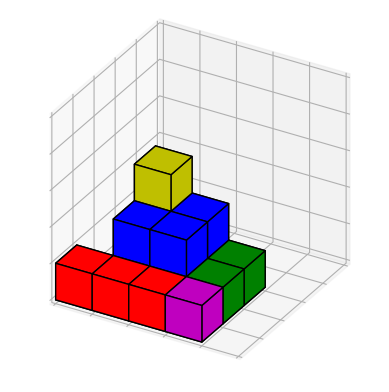

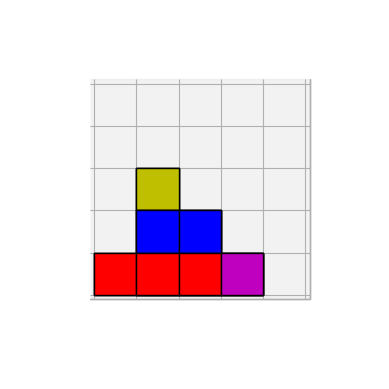

a


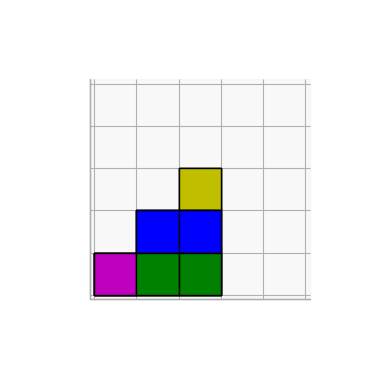

b


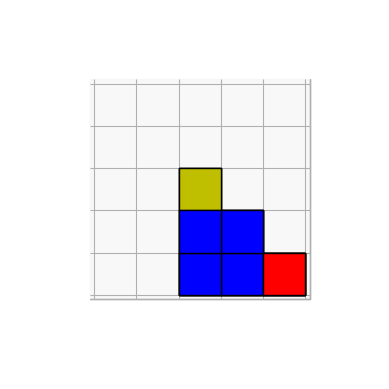

c


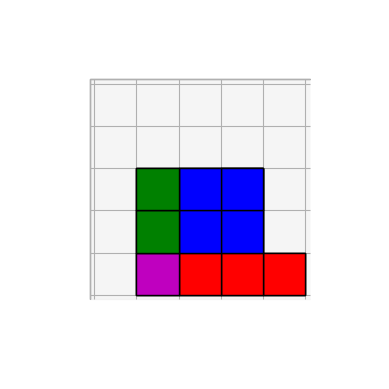

d


Enter a,b,c or d: c


correct
You took 0.83 seconds


In [10]:
#Question 3

#Welcome
print("Welcome to the Spatial Resoning Test (SRT) Question 3")
time.sleep(1)
print("Please choose the 2D projection that cannot be obtained by rotating the 3D arrangement in space.")
time.sleep(1)


# Q3 cubes drawing
cubes3 = np.full((5,5,5),'')
cubes3[0:3,0,0] = 'r' 
cubes3[3,1:3,0] = 'g' 
cubes3[1:3,1:3,0:2] = 'b' 
cubes3[3,0,0] = 'm'
cubes3[1,2,2] = 'y'
draw_cubes(cubes3)
time.sleep(1)


#draw projections
draw_cubes(cubes3, view='xz')# draw the side view in XZ direction
print("a")
draw_cubes(cubes3, view='yz')# draw the side view in YZ direction
print("b")
draw_cubes(cubes3, view='-yz')# draw the side view in -YZ direction (other side)
print("c")
draw_cubes(cubes3, view='-xy')# draw the view from bottom in XY plane
print("d")
start_time_q3=time.time()

#interaction with user 
q3_ans = input ("Enter a,b,c or d:")

if q3_ans == "c":
    print ("correct")
    score = score + 1
    q3_mark = 1
else:
    print ("The correct answer is c")
    q3_mark = 0
    
end_time_q3=time.time()
time_taken_q3=end_time_q3 - start_time_q3
print (f"You took {time_taken_q3:.2f} seconds")

In [11]:
#conclusion
time_taken_sum = time_taken_q1 + time_taken_q2 + time_taken_q3
print ("Congratulations, you have finished the Spatial Resoning Test (SRT).")
print (f"You took {time_taken_sum:.2f} seconds to answer all three questions.")
print (f"You scored {score}/3.")

Congratulations, you have finished the Spatial Resoning Test (SRT).
You took 3.20 seconds to answer all three questions.
You scored 3/3.


In [12]:
#save in local disk

#creating dataframe to store the results
overall_result = {
    'Student ID': [f'{student_ID}'],
    'Group Number': [f'{group_number}'],
    'Q1 Answer': [f'{q1_ans}'],
    'Q1 Mark': [f'{q1_mark}'],
    'Q2 Answer': [f'{q2_ans}'],
    'Q2 Mark': [f'{q2_mark}'],
    'Q3 Answer': [f'{q3_ans}'],
    'Q3 Mark': [f'{q3_mark}'],
    'Time (s)': [f'{time_taken_sum:.2f}'],
    'Score (out of 3)': [f'{score}'],
}

overall_result = pd.DataFrame(overall_result)
overall_result

,Student ID,Group Number,Q1 Answer,Q1 Mark,Q2 Answer,Q2 Mark,Q3 Answer,Q3 Mark,Time (s),Score (out of 3)
0,tesst,tesst,a,1,b,1,c,1,3.20,3


In [13]:
#save in google form
form_url = 'https://docs.google.com/forms/d/e/1FAIpQLSeJe1fSLEzfx8iyUsECnEqmCD5_oBdYGofO_sGPC0x9HxdEEA/viewform'
send_to_google_form(overall_result,form_url)

True